In [1]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

from imutils import paths
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, BCELoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, Sigmoid
from torch.optim import Adam, SGD

import os
import joblib
import torch
import random
import albumentations
import matplotlib.pyplot as plt
import argparse
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from PIL import Image
from tqdm import tqdm
from torchvision import models as models
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

In [ ]:
#!unzip "/content/drive/MyDrive/Owen/dir.zip" -d "/content/drive/MyDrive/Owen/data/"

In [ ]:
labelled_data = pd.read_csv("/content/drive/MyDrive/Owen/data/train_set/train.csv")

OSError: ignored

In [ ]:
labelled_data = labelled_data.drop("Unnamed: 0", axis="columns")
labelled_data = labelled_data.rename(columns={'Unnamed: 0.1':'image_name'})

In [ ]:
labelled_data['image_path'] = "/content/drive/MyDrive/Owen/data/train_set/" + labelled_data['image_name'].astype(str) + ".jpeg"

In [ ]:
gss = GroupShuffleSplit(n_splits=2, train_size=0.8/0.9, random_state=42)
gss.get_n_splits()
groups = np.array(labelled_data["road_id"])

In [ ]:
train,test = next(gss.split(X = labelled_data, groups = groups))

In [ ]:
xtrain = labelled_data.iloc[train].image_path.values
xtest = labelled_data.iloc[test].image_path.values
ytrain = labelled_data.iloc[train].cracking_binary.values
ytest = labelled_data.iloc[test].cracking_binary.values

In [ ]:
#(xtrain, xtest, ytrain, ytest) = (train_test_split(xtest, ytest, 
                                #test_size=1-0.8/0.9, random_state=42))

In [ ]:
#(xtrain, xtest, ytrain, ytest) = (train_test_split(xtest, ytest, 
                                #test_size=1-0.8/0.9, random_state=42))

In [ ]:
# image dataset module
class pano_images(Dataset):
    def __init__(self, path, labels, tfms=None):
        self.X = path
        self.y = labels
        # apply augmentations
        if tfms == 0: # if validating
            self.aug = albumentations.Compose([
                albumentations.Resize(237, 474, always_apply=True),
                albumentations.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225], always_apply=True)
            ])
        else: # if training
            self.aug = albumentations.Compose([
                albumentations.Resize(237, 474, always_apply=True),
                albumentations.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225], always_apply=True)
            ])
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        image = Image.open(self.X[i])
        image = self.aug(image=np.array(image))['image']
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        label = self.y[i]
        return torch.tensor(image, dtype=torch.float), torch.tensor(label, dtype=torch.long)

In [ ]:
train_data = pano_images(xtrain, ytrain, tfms=1)
test_data = pano_images(xtest, ytest, tfms=0)
 
# dataloaders
trainloader = DataLoader(train_data, batch_size=1000, shuffle=True,num_workers=4)
testloader = DataLoader(test_data, batch_size=1000, shuffle=False)

In [ ]:
# visualizing images
i = 100
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(train_data[i][0][2], cmap='gray')
plt.subplot(222), plt.imshow(train_data[i+25][0][2], cmap='gray')
plt.subplot(223), plt.imshow(train_data[i+50][0][2], cmap='gray')
plt.subplot(224), plt.imshow(train_data[i+75][0][2], cmap='gray')

In [ ]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer (output 320,000)
            Conv2d(3, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer (output 80,000)
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer (output 20,000)
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer (output 1,250)
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(1624, 812),
            Linear(812, 1),
            Sigmoid()
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x).squeeze()
        return x

In [ ]:
# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.0003)
# defining the loss function
criterion = BCELoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_run

In [2]:
summary(model, (3, 224, 224))

NameError: ignored

In [ ]:
''' SEED Everything '''
def seed_everything(SEED=42):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True 
SEED=42
seed_everything(SEED=SEED)
''' SEED Everything '''
# set computation device
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}")

Computation device: cuda:0


In [ ]:
#validation function
def validate(model, test_dataloader):
    print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(test_dataloader), total=int(len(test_data)/test_dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)
            loss = criterion(outputs.float(), target.float())
            val_running_loss += loss.item()
            preds = torch.round(outputs.data)
            val_running_correct += (preds == target).sum().item()
            true_positives += ((preds == 1)&(target == 1)).sum().item()
            true_negatives += ((preds == 0)&(target == 0)).sum().item()
            false_positives += ((preds == 1)&(target == 0)).sum().item()
            false_negatives += ((preds == 0)&(target == 1)).sum().item()
        
        precision = true_positives/(true_positives+false_positives)
        recall = true_positives/(true_positives+false_negatives)
        if ((precision>0)&(recall>0)):
          f1 = 2 * (precision*recall)/(precision+recall)
        else:
          f1 = 0
        val_loss = val_running_loss/int(len(test_data)/test_dataloader.batch_size)
        val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}')
        print(f"Recall: {recall:.4f}, Precision: {precision:.2f}, F1: {f1:.2f}")
        
        return val_loss, val_accuracy, f1

In [ ]:
# training function
def fit(model, train_dataloader):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    for i, data in tqdm(enumerate(train_dataloader), total=int(len(train_data)/train_dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs.float(), target.float())
        train_running_loss += loss.item()
        preds = torch.round(outputs.data)
        train_running_correct += (preds == target).sum().item()
        true_positives += ((preds == 1)&(target == 1)).sum().item()
        true_negatives += ((preds == 0)&(target == 0)).sum().item()
        false_positives += ((preds == 1)&(target == 0)).sum().item()
        false_negatives += ((preds == 0)&(target == 1)).sum().item()
        loss.backward()
        optimizer.step()
        
    precision = true_positives/(true_positives+false_positives)
    recall = true_positives/(true_positives+false_negatives)
    f1 = 2 * (precision*recall)/(precision+recall)
    train_loss = train_running_loss/int(len(train_data)/train_dataloader.batch_size)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}")
    print(f"Recall: {recall:.4f}, Precision: {precision:.2f}, F1: {f1:.2f}")
    
    return train_loss, train_accuracy, f1

In [ ]:
train_loss , train_accuracy , train_f1 = [], [], []
val_loss , val_accuracy, val_f1 = [], [], []
start = time.time()
epochs = 75
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy, train_epoch_f1 = fit(model, trainloader)
    val_epoch_loss, val_epoch_accuracy, val_epoch_f1 = validate(model, testloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    train_f1.append(train_epoch_f1)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    val_f1.append(val_epoch_f1)
    path = "/content/drive/MyDrive/Owen/output/epoch" + str(epoch)
    torch.save(model.state_dict(), path)
end = time.time()
print(f"{(end-start)/60:.3f} minutes")

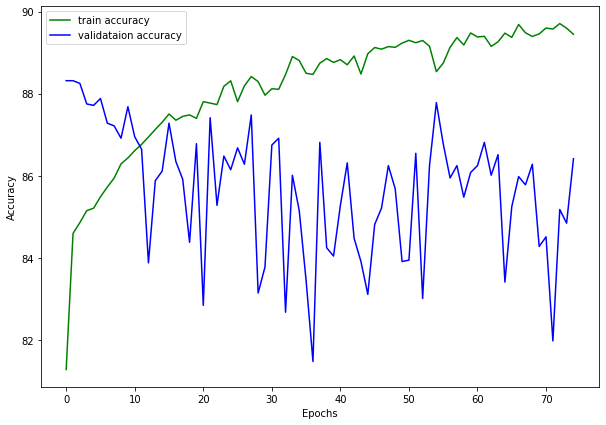

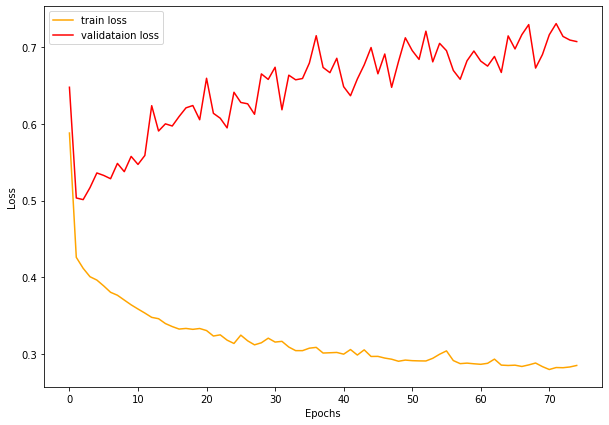

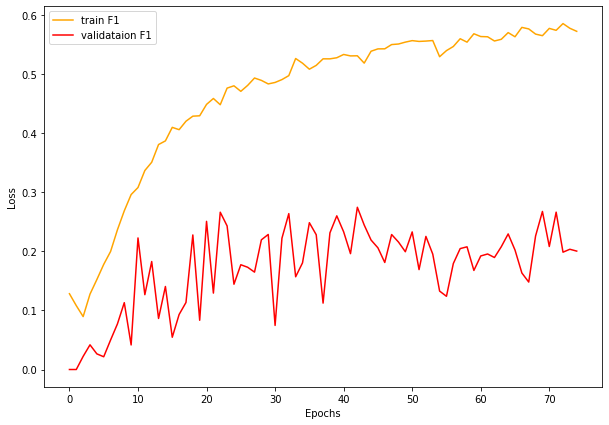

In [ ]:
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
#plt.savefig('/content/drive/MyDrive/Owen/accuracy.png')
plt.show()
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.savefig('/content/drive/MyDrive/Owen/loss.png')
plt.show()
# F1 plots
plt.figure(figsize=(10, 7))
plt.plot(train_f1, color='orange', label='train F1')
plt.plot(val_f1, color='red', label='validataion F1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.savefig('/content/drive/MyDrive/Owen/loss.png')
plt.show()

In [ ]:
results = pd.DataFrame({'Train Accuracy':train_accuracy,
                        'Validation Accuracy':val_accuracy,
                        'Train Loss':train_loss, 
                        'Validation Loss':val_loss,
                        'Train F1':train_f1,
                        'Validation F1':val_f1}, 
                         columns=['Train Accuracy','Validation Accuracy', 'Train Loss', 'Validation Loss',
                                  'Train F1', "Validation F1"])

In [ ]:
results.to_csv("/content/drive/MyDrive/Owen/results.csv")

In [ ]:
labelled_data.head(10)

,image_name,road_id,inspection_date,inspecting_org,transverse_unevenness,longitudinal_unevenness,unevenness,fraying,edge_damage,cracking,joint_filling,joint_width,setting,inspection_note,road_id_shapefile,object_type,road_type,surface_type,type_extra,colour,year,year_last,year_out,area,road_usage,lane_type,road_traffic,street_name,administrator,url,pano_lat,pano_long,pano_timestamp,pano_surface_type,transverse_unevenness_binary,unevenness_binary,fraying_binary,edge_damage_binary,cracking_binary,image_path,inspection_id
0,344,{03E9F666-882E-4EFB-830E-2BB57D4D35F5},2019-05-01,NaN,G,NaN,G,G,G,G,NaN,NaN,G,NaN,{03E9F666-882E-4EFB-830E-2BB57D4D35F5},Verhardingsobject,Asfaltverharding,Dichte deklagen,Asfaltbeton,Grijs,1999,2013.0,NaN,71.643224,Rijbaan,NaN,5 - Weg in woongebied,Van Walbeeckstraat,Stadsdeel West,https://panorama.data.amsterdam.nl/panorama/20...,52.360808,4.851067,2019-04-26T07:43:02.256640Z,L,0,0,0,0,0,/content/drive/MyDrive/Owen/data/train_set/344...,{03E9F666-882E-4EFB-830E-2BB57D4D35F5}2019-05-01
1,345,{03E9F666-882E-4EFB-830E-2BB57D4D35F5},2019-05-01,NaN,G,NaN,G,G,G,G,NaN,NaN,G,NaN,{03E9F666-882E-4EFB-830E-2BB57D4D35F5},Verhardingsobject,Asfaltverharding,Dichte deklagen,Asfaltbeton,Grijs,1999,2013.0,NaN,71.643224,Rijbaan,NaN,5 - Weg in woongebied,Van Walbeeckstraat,Stadsdeel West,https://panorama.data.amsterdam.nl/panorama/20...,52.360762,4.851068,2019-04-26T07:43:01.556610Z,L,0,0,0,0,0,/content/drive/MyDrive/Owen/data/train_set/345...,{03E9F666-882E-4EFB-830E-2BB57D4D35F5}2019-05-01
2,346,{03E9F666-882E-4EFB-830E-2BB57D4D35F5},2019-05-01,NaN,G,NaN,G,G,G,G,NaN,NaN,G,NaN,{03E9F666-882E-4EFB-830E-2BB57D4D35F5},Verhardingsobject,Asfaltverharding,Dichte deklagen,Asfaltbeton,Grijs,1999,2013.0,NaN,71.643224,Rijbaan,NaN,5 - Weg in woongebied,Van Walbeeckstraat,Stadsdeel West,https://panorama.data.amsterdam.nl/panorama/20...,52.360854,4.851065,2019-04-26T07:43:03.006790Z,L,0,0,0,0,0,/content/drive/MyDrive/Owen/data/train_set/346...,{03E9F666-882E-4EFB-830E-2BB57D4D35F5}2019-05-01
3,347,{03E9F666-882E-4EFB-830E-2BB57D4D35F5},2019-05-01,NaN,G,NaN,G,G,G,G,NaN,NaN,G,NaN,{03E9F666-882E-4EFB-830E-2BB57D4D35F5},Verhardingsobject,Asfaltverharding,Dichte deklagen,Asfaltbeton,Grijs,1999,2013.0,NaN,71.643224,Rijbaan,NaN,5 - Weg in woongebied,Van Walbeeckstraat,Stadsdeel West,https://panorama.data.amsterdam.nl/panorama/20...,52.360716,4.851070,2019-04-26T07:43:00.876650Z,L,0,0,0,0,0,/content/drive/MyDrive/Owen/data/train_set/347...,{03E9F666-882E-4EFB-830E-2BB57D4D35F5}2019-05-01
4,413,{0511ED15-1D31-4D74-9411-02421142AB46},2019-05-15,NaN,G,NaN,G,G,G,G,NaN,NaN,G,NaN,{0511ED15-1D31-4D74-9411-02421142AB46},Verhardingsobject,Asfaltverharding,Dichte deklagen,Steenmastiekasfalt,Grijs,1980,2017.0,2017.0,652.369340,Rijbaan,NaN,2 - Zwaar belaste weg,Haarlemmerweg,Verkeer & Openbare Ruimte,https://panorama.data.amsterdam.nl/panorama/20...,52.385279,4.864175,2019-04-16T09:46:51.411300Z,L,0,0,0,0,0,/content/drive/MyDrive/Owen/data/train_set/413...,{0511ED15-1D31-4D74-9411-02421142AB46}2019-05-15
5,414,{0511ED15-1D31-4D74-9411-02421142AB46},2019-05-15,NaN,G,NaN,G,G,G,G,NaN,NaN,G,NaN,{0511ED15-1D31-4D74-9411-02421142AB46},Verhardingsobject,Asfaltverharding,Dichte deklagen,Steenmastiekasfalt,Grijs,1980,2017.0,2017.0,652.369340,Rijbaan,NaN,2 - Zwaar belaste weg,Haarlemmerweg,Verkeer & Openbare Ruimte,https://panorama.data.amsterdam.nl/panorama/20...,52.385278,4.864101,2019-04-16T09:46:51.856270Z,L,0,0,0,0,0,/content/drive/MyDrive/Owen/data/train_set/414...,{0511ED15-1D31-4D74-9411-02421142AB46}2019-05-15
6,415,{0511ED15-1D31-4D74-9411-02421142AB46},2019-05-15,NaN,G,NaN,G,G,G,G,NaN,NaN,G,NaN,{0511ED15-1D31-4D74-9411-02421142AB46},Verhardingsobject,Asfaltverharding,Dichte deklagen,Steenmastiekasfalt,Grijs,1980,2017.0,2017.0,652.369340,Rijbaan,NaN,2 - Zwaar belaste weg,Haarlemmerweg,Verkeer & Openbare Ruimte,https://panorama.data.amsterdam.nl/panorama/20...,52.385281,4.864249,2019-04-16T09:46:50.961360Z,L,0,0,0,0,0,/content/drive/MyDrive/Owen/data/trai

In [ ]:
labelled_data['inspection_id'] = labelled_data['road_id'] + labelled_data['inspection_date']

In [ ]:
fulltestloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
inspection_ids = labelled_data.iloc[test].inspection_id.unique()
inspections_x = labelled_data.iloc[test].inspection_id.values
inspections_y = labelled_data.loc[test,'cracking_binary'].groupby(by=inspections_x).max()

In [ ]:
fulltrainloader = DataLoader(train_data, batch_size=len(train_data), shuffle=False)
inspection_ids = labelled_data.iloc[train].inspection_id.unique()
inspections_x = labelled_data.iloc[train].inspection_id.values
inspections_y = labelled_data.loc[train,'cracking_binary'].groupby(by=inspections_x).max()

In [ ]:
def inspection_level_f1_max(model, inspections_x, inspections_y, inspection_ids, xtest, ytest):
  model.eval()
  true_positives = 0
  true_negatives = 0
  false_positives = 0
  false_negatives = 0
  for i,inspection in tqdm(enumerate(inspection_ids), total=len(inspection_ids)):
    images_x = xtest[inspections_x==inspection]
    images_y = ytest[inspections_x==inspection]
    test_data = pano_images(images_x, images_y, tfms=0)
    with torch.no_grad():
      test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
      for i, data in enumerate(test_dataloader):
        data = data[0].to(device)
        outputs = model(data)
        road_pred = torch.round(torch.max(outputs.data)).item()
        road_truth = max(images_y)
        true_positives += ((road_pred == 1)&(road_truth == 1)).sum().item()
        true_negatives += ((road_pred == 0)&(road_truth == 0)).sum().item()
        false_positives += ((road_pred == 1)&(road_truth == 0)).sum().item()
        false_negatives += ((road_pred == 0)&(road_truth == 1)).sum().item()
  precision = true_positives/(true_positives+false_positives)
  print("Precision = ", precision)
  recall = true_positives/(true_positives+false_negatives)
  print("Recall = ",recall)
  if ((precision>0)&(recall>0)):
    f1 = 2 * (precision*recall)/(precision+recall)
  else:
    f1 = 0
  print(f1)
  return f1

In [ ]:
def inspection_level_f1_mean(model, inspections_x, inspections_y, inspection_ids, xtest, ytest):
  print("Function")
  model.eval()
  print("Model eval")
  true_positives = 0
  true_negatives = 0
  false_positives = 0
  false_negatives = 0
  for i,inspection in tqdm(enumerate(inspection_ids), total=len(inspection_ids)):
    images_x = xtest[inspections_x==inspection]
    images_y = ytest[inspections_x==inspection]
    print(images_x, images_y)
    test_data = pano_images(images_x, images_y, tfms=0)
    with torch.no_grad():
      test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
      for i, data in enumerate(test_dataloader):
        data = data[0].to(device)
        outputs = model(data)
        road_pred = torch.round(torch.mean(outputs.data)).item()
        road_truth = max(images_y)
        print(road_pred, road_truth)
        true_positives += ((road_pred == 1)&(road_truth == 1)).sum().item()
        true_negatives += ((road_pred == 0)&(road_truth == 0)).sum().item()
        false_positives += ((road_pred == 1)&(road_truth == 0)).sum().item()
        false_negatives += ((road_pred == 0)&(road_truth == 1)).sum().item()
  if true_positives+false_positives>0:
    precision = true_positives/(true_positives+false_positives)
  else: precision = 0
  print("Precision = ", precision)
  if true_positives>0:
    recall = true_positives/(true_positives+false_negatives)
  else:
    recall=0
  print("Recall = ",recall)
  if ((precision>0)&(recall>0)):
    f1 = 2 * (precision*recall)/(precision+recall)
  else:
    f1 = 0
  print(f1)
  return f1

In [ ]:
from torchvision import models
from torchsummary import summary

model.load_state_dict(torch.load("/content/drive/MyDrive/Owen/output/epoch" + str(11)))

summary(model,(3,237,474))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 237, 474]             112
       BatchNorm2d-2          [-1, 4, 237, 474]               8
              ReLU-3          [-1, 4, 237, 474]               0
         MaxPool2d-4          [-1, 4, 118, 237]               0
            Conv2d-5          [-1, 4, 118, 237]             148
       BatchNorm2d-6          [-1, 4, 118, 237]               8
              ReLU-7          [-1, 4, 118, 237]               0
         MaxPool2d-8           [-1, 4, 59, 118]               0
            Conv2d-9           [-1, 4, 59, 118]             148
      BatchNorm2d-10           [-1, 4, 59, 118]               8
             ReLU-11           [-1, 4, 59, 118]               0
        MaxPool2d-12            [-1, 4, 29, 59]               0
           Conv2d-13            [-1, 4, 29, 59]             148
      BatchNorm2d-14            [-1, 4,

In [ ]:
scores = []
for epoch in range(75):
  print("Epoch = ", epoch)
  path = "/content/drive/MyDrive/Owen/output/epoch" + str(epoch)
  model.load_state_dict(torch.load(path))
  f1 = inspection_level_f1_max(model,inspections_x,inspections_y, inspection_ids, xtrain, ytrain)
  scores.append(f1)

  0%|          | 0/1342 [00:00<?, ?it/s]

Epoch =  0


100%|██████████| 1342/1342 [1:08:41<00:00,  3.07s/it]


Precision =  0.6153846153846154
Recall =  0.042328042328042326
0.0792079207920792
Epoch =  1


100%|██████████| 1342/1342 [03:03<00:00,  7.33it/s]


Precision =  0.7142857142857143
Recall =  0.026455026455026454
0.051020408163265314
Epoch =  2


100%|██████████| 1342/1342 [03:03<00:00,  7.32it/s]


Precision =  0.5789473684210527
Recall =  0.1164021164021164
0.1938325991189427
Epoch =  3


100%|██████████| 1342/1342 [03:02<00:00,  7.36it/s]


Precision =  0.48148148148148145
Recall =  0.20634920634920634
0.28888888888888886
Epoch =  4


100%|██████████| 1342/1342 [03:02<00:00,  7.34it/s]


Precision =  0.5333333333333333
Recall =  0.21164021164021163
0.30303030303030304
Epoch =  5


100%|██████████| 1342/1342 [03:02<00:00,  7.34it/s]


Precision =  0.5466666666666666
Recall =  0.21693121693121692
0.3106060606060606
Epoch =  6


100%|██████████| 1342/1342 [03:05<00:00,  7.25it/s]


Precision =  0.4824561403508772
Recall =  0.291005291005291
0.36303630363036304
Epoch =  7


100%|██████████| 1342/1342 [03:10<00:00,  7.06it/s]


Precision =  0.48026315789473684
Recall =  0.3862433862433862
0.4281524926686217
Epoch =  8


100%|██████████| 1342/1342 [03:10<00:00,  7.06it/s]


Precision =  0.430939226519337
Recall =  0.4126984126984127
0.4216216216216216
Epoch =  9


100%|██████████| 1342/1342 [03:05<00:00,  7.23it/s]


Precision =  0.5673076923076923
Recall =  0.31216931216931215
0.40273037542662116
Epoch =  10


  0%|          | 5/1342 [00:00<00:41, 31.95it/s]

Precision =  0.3897058823529412
Recall =  0.5608465608465608
0.45986984815618215
Epoch =  11


100%|██████████| 1342/1342 [03:08<00:00,  7.12it/s]


Precision =  0.4302788844621514
Recall =  0.5714285714285714
0.49090909090909085
Epoch =  12


100%|██████████| 1342/1342 [03:08<00:00,  7.14it/s]


Precision =  0.3341121495327103
Recall =  0.7566137566137566
0.46353322528363045
Epoch =  13


100%|██████████| 1342/1342 [03:07<00:00,  7.15it/s]


Precision =  0.4117647058823529
Recall =  0.6296296296296297
0.49790794979079495
Epoch =  14


100%|██████████| 1342/1342 [03:07<00:00,  7.18it/s]


Precision =  0.43728813559322033
Recall =  0.6825396825396826
0.5330578512396694
Epoch =  15


 69%|██████▊   | 920/1342 [02:11<01:11,  5.91it/s]

KeyboardInterrupt: ignored

In [ ]:
from sklearn.metrics import f1_score
inspection_ids = labelled_data.iloc[test].inspection_id.unique()
inspections_x = labelled_data.iloc[test].inspection_id.values
inspections_y = labelled_data.loc[test,'cracking_binary'].groupby(by=inspections_x).max()
f1_scores_max = []
f1_scores_mean = []
f1_scores_majority = []
f1_scores_top2 = []
for a in range(75):
  path = "/content/drive/MyDrive/Owen/output/epoch" + str(a)
  model.load_state_dict(torch.load(path))
  model.eval
  road_truths = []
  max_preds = []
  mean_preds = []
  majority_preds = []
  toptwo_preds = []
  for i,inspection in tqdm(enumerate(inspection_ids), total=len(inspection_ids)):
      images_x = xtest[inspections_x==inspection]
      images_y = ytest[inspections_x==inspection]
      test_data = pano_images(images_x, images_y, tfms=0)
      with torch.no_grad():
        test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
        for i, data in enumerate(test_dataloader):
          data = data[0].to(device)
          outputs = model(data)
          road_truth = np.amax(images_y)
          max_pred = torch.round(torch.max(outputs.data)).item()
          mean_pred = torch.round(torch.mean(outputs.data)).item()
          majority_pred = torch.round(torch.mean(torch.round(outputs.data))).item()
          if len(outputs.size())==0:
            top2_pred = torch.round(torch.max(outputs)).item()
          else:
            top2 = torch.topk(outputs, 2).values
            top2_pred = torch.round(torch.mean(top2)).item()
          road_truths.append(road_truth)
          max_preds.append(max_pred)
          mean_preds.append(mean_pred)
          majority_preds.append(majority_pred)
          toptwo_preds.append(top2_pred)
  f1_max = f1_score(road_truths, max_preds)
  f1_mean = f1_score(road_truths, mean_preds)
  f1_majority = f1_score(road_truths, majority_preds)
  f1_top2 = f1_score(road_truths, toptwo_preds)
  print(f1_max, f1_mean, f1_majority, f1_top2)
  f1_scores_max.append(f1_max)
  f1_scores_mean.append(f1_mean)
  f1_scores_majority.append(f1_majority)
  f1_scores_top2.append(f1_top2)

100%|██████████| 167/167 [00:20<00:00,  8.17it/s]


0.0 0.0 0.0 0.0


100%|██████████| 167/167 [00:20<00:00,  8.15it/s]


0.0 0.0 0.0 0.0


100%|██████████| 167/167 [00:20<00:00,  8.15it/s]


0.1904761904761905 0.0 0.0 0.1904761904761905


100%|██████████| 167/167 [00:20<00:00,  8.19it/s]


0.1818181818181818 0.0 0.0 0.1818181818181818


100%|██████████| 167/167 [00:20<00:00,  8.20it/s]


0.1818181818181818 0.10526315789473684 0.0 0.1818181818181818


100%|██████████| 167/167 [00:20<00:00,  8.25it/s]


0.1818181818181818 0.10526315789473684 0.0 0.1904761904761905


100%|██████████| 167/167 [00:20<00:00,  8.25it/s]


0.3225806451612903 0.19999999999999998 0.0 0.32


100%|██████████| 167/167 [00:20<00:00,  8.16it/s]


0.25641025641025644 0.1739130434782609 0.1739130434782609 0.28571428571428575


100%|██████████| 167/167 [00:20<00:00,  8.19it/s]


0.32558139534883723 0.1739130434782609 0.1739130434782609 0.28571428571428575


100%|██████████| 167/167 [00:20<00:00,  8.25it/s]


0.3225806451612903 0.1904761904761905 0.1904761904761905 0.3448275862068966


100%|██████████| 167/167 [00:20<00:00,  8.26it/s]


0.23076923076923078 0.16 0.16666666666666666 0.23255813953488372


100%|██████████| 167/167 [00:20<00:00,  8.25it/s]


0.2916666666666667 0.1739130434782609 0.1739130434782609 0.25


  1%|          | 1/167 [00:00<00:26,  6.17it/s]

0.28169014084507044 0.16 0.16 0.2903225806451613


100%|██████████| 167/167 [00:20<00:00,  8.18it/s]


0.3448275862068966 0.1739130434782609 0.0909090909090909 0.3404255319148936


100%|██████████| 167/167 [00:20<00:00,  8.29it/s]


0.2909090909090909 0.1739130434782609 0.1739130434782609 0.2978723404255319


100%|██████████| 167/167 [00:20<00:00,  8.22it/s]


0.3157894736842105 0.09523809523809525 0.09523809523809525 0.303030303030303


100%|██████████| 167/167 [00:20<00:00,  8.27it/s]


0.25925925925925924 0.1739130434782609 0.0909090909090909 0.3


100%|██████████| 167/167 [00:20<00:00,  8.30it/s]


0.29508196721311475 0.08695652173913045 0.08695652173913045 0.27450980392156865


100%|██████████| 167/167 [00:20<00:00,  8.31it/s]


0.30000000000000004 0.30769230769230765 0.16 0.29411764705882354


100%|██████████| 167/167 [00:20<00:00,  8.28it/s]


0.2978723404255319 0.08695652173913045 0.08695652173913045 0.30769230769230765


100%|██████████| 167/167 [00:20<00:00,  8.34it/s]


0.2765957446808511 0.3448275862068966 0.3448275862068966 0.2619047619047619


100%|██████████| 167/167 [00:20<00:00,  8.31it/s]


0.3137254901960784 0.08695652173913045 0.08695652173913045 0.36842105263157887


100%|██████████| 167/167 [00:20<00:00,  8.35it/s]


0.282051282051282 0.3448275862068966 0.3448275862068966 0.3076923076923077


100%|██████████| 167/167 [00:20<00:00,  8.34it/s]


0.33333333333333337 0.2857142857142857 0.2857142857142857 0.3333333333333333


100%|██████████| 167/167 [00:20<00:00,  8.33it/s]


0.2647058823529412 0.08695652173913045 0.08695652173913045 0.2962962962962963


100%|██████████| 167/167 [00:19<00:00,  8.40it/s]


0.2758620689655173 0.08695652173913045 0.08333333333333333 0.2857142857142857


100%|██████████| 167/167 [00:19<00:00,  8.36it/s]


0.27692307692307694 0.2962962962962963 0.15384615384615383 0.3272727272727273


100%|██████████| 167/167 [00:19<00:00,  8.36it/s]


0.2909090909090909 0.08695652173913045 0.08695652173913045 0.34782608695652173


100%|██████████| 167/167 [00:20<00:00,  8.33it/s]


0.27272727272727276 0.3448275862068966 0.2222222222222222 0.26666666666666666


100%|██████████| 167/167 [00:19<00:00,  8.37it/s]


0.27272727272727276 0.30769230769230765 0.16 0.282051282051282


100%|██████████| 167/167 [00:20<00:00,  8.33it/s]


0.2962962962962963 0.08695652173913045 0.0 0.24390243902439024


100%|██████████| 167/167 [00:19<00:00,  8.38it/s]


0.3235294117647059 0.24 0.08333333333333333 0.3050847457627119


100%|██████████| 167/167 [00:19<00:00,  8.44it/s]


0.26804123711340205 0.3448275862068966 0.33333333333333337 0.2619047619047619


100%|██████████| 167/167 [00:19<00:00,  8.40it/s]


0.26315789473684215 0.08695652173913045 0.08695652173913045 0.26666666666666666


100%|██████████| 167/167 [00:19<00:00,  8.42it/s]


0.2619047619047619 0.08695652173913045 0.08695652173913045 0.23529411764705882


100%|██████████| 167/167 [00:19<00:00,  8.44it/s]


0.26 0.2857142857142857 0.2857142857142857 0.25882352941176473


100%|██████████| 167/167 [00:19<00:00,  8.38it/s]


0.25 0.3448275862068966 0.2857142857142857 0.25


100%|██████████| 167/167 [00:19<00:00,  8.41it/s]


0.2903225806451613 0.08695652173913045 0.0 0.2916666666666667


100%|██████████| 167/167 [00:19<00:00,  8.39it/s]


0.24719101123595505 0.24 0.23076923076923078 0.26666666666666666


100%|██████████| 167/167 [00:19<00:00,  8.48it/s]


0.25263157894736843 0.3448275862068966 0.2857142857142857 0.2619047619047619


100%|██████████| 167/167 [00:19<00:00,  8.45it/s]


0.2650602409638554 0.2962962962962963 0.23076923076923078 0.2898550724637681


100%|██████████| 167/167 [00:19<00:00,  8.39it/s]


0.25 0.08695652173913045 0.0 0.2962962962962963


100%|██████████| 167/167 [00:19<00:00,  8.38it/s]


0.26373626373626374 0.2857142857142857 0.2857142857142857 0.27499999999999997


100%|██████████| 167/167 [00:20<00:00,  8.22it/s]


0.24742268041237114 0.2857142857142857 0.2857142857142857 0.2716049382716049


100%|██████████| 167/167 [00:20<00:00,  8.14it/s]


0.23529411764705882 0.27586206896551724 0.21428571428571427 0.26373626373626374


100%|██████████| 167/167 [00:20<00:00,  8.18it/s]


0.24444444444444446 0.30769230769230765 0.16666666666666666 0.28947368421052627


100%|██████████| 167/167 [00:20<00:00,  8.08it/s]


0.22727272727272727 0.08695652173913045 0.0 0.24657534246575344


100%|██████████| 167/167 [00:20<00:00,  8.25it/s]


0.23255813953488372 0.24 0.0 0.2285714285714286


100%|██████████| 167/167 [00:20<00:00,  8.12it/s]


0.22727272727272727 0.16 0.0 0.2191780821917808


100%|██████████| 167/167 [00:21<00:00,  7.80it/s]


0.25263157894736843 0.08695652173913045 0.0 0.25316455696202533


100%|██████████| 167/167 [00:21<00:00,  7.73it/s]


0.24489795918367346 0.2857142857142857 0.15384615384615383 0.2619047619047619


100%|██████████| 167/167 [00:20<00:00,  8.20it/s]


0.2647058823529412 0.08695652173913045 0.0 0.27118644067796616


100%|██████████| 167/167 [00:20<00:00,  7.97it/s]


0.24299065420560745 0.2857142857142857 0.2222222222222222 0.24444444444444446


100%|██████████| 167/167 [00:20<00:00,  8.02it/s]


0.23076923076923075 0.08695652173913045 0.0 0.24615384615384614


100%|██████████| 167/167 [00:20<00:00,  8.13it/s]


0.34782608695652173 0.0909090909090909 0.0 0.30769230769230765


100%|██████████| 167/167 [00:20<00:00,  8.13it/s]


0.27692307692307694 0.0 0.0 0.27450980392156865


100%|██████████| 167/167 [00:20<00:00,  8.23it/s]


0.26666666666666666 0.08695652173913045 0.0 0.24242424242424243


100%|██████████| 167/167 [00:20<00:00,  8.17it/s]


0.26315789473684215 0.24 0.08695652173913045 0.2622950819672131


100%|██████████| 167/167 [00:20<00:00,  8.21it/s]


0.2298850574712644 0.16666666666666666 0.08695652173913045 0.24657534246575344


100%|██████████| 167/167 [00:20<00:00,  8.29it/s]


0.2380952380952381 0.08695652173913045 0.0 0.23880597014925373


100%|██████████| 167/167 [00:20<00:00,  8.19it/s]


0.24691358024691357 0.08333333333333333 0.0 0.23880597014925373


100%|██████████| 167/167 [00:20<00:00,  8.27it/s]


0.26666666666666666 0.08695652173913045 0.0 0.2807017543859649


100%|██████████| 167/167 [00:20<00:00,  8.21it/s]


0.2528735632183908 0.08333333333333333 0.0 0.2285714285714286


100%|██████████| 167/167 [00:20<00:00,  8.29it/s]


0.26315789473684215 0.24 0.16666666666666666 0.25


100%|██████████| 167/167 [00:20<00:00,  8.25it/s]


0.21359223300970875 0.2222222222222222 0.08 0.22222222222222227


100%|██████████| 167/167 [00:20<00:00,  8.20it/s]


0.2268041237113402 0.16 0.0 0.24691358024691357


100%|██████████| 167/167 [00:20<00:00,  8.30it/s]


0.23529411764705882 0.0 0.0 0.2285714285714286


100%|██████████| 167/167 [00:20<00:00,  8.16it/s]


0.23529411764705882 0.0 0.0 0.19444444444444445


100%|██████████| 167/167 [00:20<00:00,  8.20it/s]


0.2247191011235955 0.23076923076923078 0.08333333333333333 0.25


100%|██████████| 167/167 [00:20<00:00,  8.17it/s]


0.24489795918367346 0.2222222222222222 0.15384615384615383 0.22727272727272727


100%|██████████| 167/167 [00:20<00:00,  8.29it/s]


0.2268041237113402 0.16 0.08333333333333333 0.23529411764705882


100%|██████████| 167/167 [00:20<00:00,  8.27it/s]


0.2407407407407407 0.27586206896551724 0.26666666666666666 0.25


100%|██████████| 167/167 [00:20<00:00,  8.10it/s]


0.23913043478260868 0.08333333333333333 0.0 0.25


100%|██████████| 167/167 [00:20<00:00,  8.15it/s]


0.2340425531914894 0.16 0.08333333333333333 0.2380952380952381


100%|██████████| 167/167 [00:20<00:00,  8.08it/s]

0.23255813953488372 0.08333333333333333 0.0 0.23880597014925373


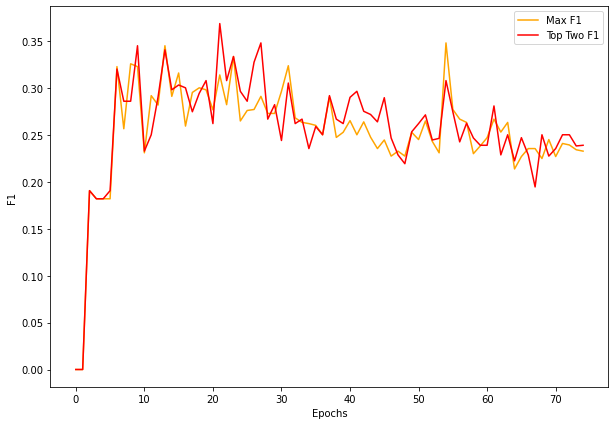

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(f1_scores_max, color='orange', label='Max F1')
plt.plot(f1_scores_top2, color='red', label='Top Two F1')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.legend()
#plt.savefig('/content/drive/MyDrive/Owen/loss.png')
plt.show()

In [ ]:
print(np.mean(f1_scores_top2))
print(np.mean(f1_scores_max))

0.2586615133513285
0.2543824631766369


In [ ]:
f1_scores_max

[0.0,
 0.0,
 0.1904761904761905,
 0.1818181818181818,
 0.1818181818181818,
 0.1818181818181818,
 0.3225806451612903,
 0.25641025641025644,
 0.32558139534883723,
 0.3225806451612903,
 0.23076923076923078,
 0.2916666666666667,
 0.28169014084507044,
 0.3448275862068966,
 0.2909090909090909,
 0.3157894736842105,
 0.25925925925925924,
 0.29508196721311475,
 0.30000000000000004,
 0.2978723404255319,
 0.2765957446808511,
 0.3137254901960784,
 0.282051282051282,
 0.33333333333333337,
 0.2647058823529412,
 0.2758620689655173,
 0.27692307692307694,
 0.2909090909090909,
 0.27272727272727276,
 0.27272727272727276,
 0.2962962962962963,
 0.3235294117647059,
 0.26804123711340205,
 0.26315789473684215,
 0.2619047619047619,
 0.26,
 0.25,
 0.2903225806451613,
 0.24719101123595505,
 0.25263157894736843,
 0.2650602409638554,
 0.25,
 0.26373626373626374,
 0.24742268041237114,
 0.23529411764705882,
 0.24444444444444446,
 0.22727272727272727,
 0.23255813953488372,
 0.22727272727272727,
 0.25263157894736843,


In [ ]:
from sklearn.metrics import f1_score
inspection_ids = labelled_data.iloc[test].inspection_id.unique()
inspections_x = labelled_data.iloc[test].inspection_id.values
inspections_y = labelled_data.loc[test,'cracking_binary'].groupby(by=inspections_x).max()
f1_scores_13 = []
path = "/content/drive/MyDrive/Owen/output/epoch" + str(13)
model.load_state_dict(torch.load(path))
model.eval
road_predictions = []
road_truths = []
for i,inspection in tqdm(enumerate(inspection_ids), total=len(inspection_ids)):
    images_x = xtest[inspections_x==inspection]
    images_y = ytest[inspections_x==inspection]
    test_data = pano_images(images_x, images_y, tfms=0)
    with torch.no_grad():
      test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
      for i, data in enumerate(test_dataloader):
        data = data[0].to(device)
        outputs = model(data)
        road_pred = outputs.data
        road_truth = images_y
        print(outputs.data)
        #road_pred = torch.round(torch.max(outputs.data)).item()
        #road_truth = max(images_y)
        #road_predictions.append(road_pred)
        #road_truths.append(road_truth)
#f1 = f1_score(road_truths, road_predictions)
#print(f1)
#f1_scores_13.append(f1)

  2%|▏         | 3/167 [00:00<00:21,  7.73it/s]

tensor([0.3343, 0.2599, 0.1946, 0.5035, 0.5621, 0.2837, 0.5729, 0.3659, 0.7059,
        0.1146, 0.1498, 0.3401, 0.0622, 0.2103, 0.2121, 0.1563, 0.1971, 0.2568,
        0.3002, 0.4399, 0.1515, 0.0350], device='cuda:0')
tensor([0.0295, 0.0370, 0.1249, 0.0645, 0.0594, 0.0241, 0.0037, 0.0346, 0.0693,
        0.0232], device='cuda:0')
tensor([0.0438, 0.0314, 0.0404, 0.0203, 0.0401], device='cuda:0')
tensor([0.1045, 0.0784, 0.0479, 0.0244, 0.0123, 0.0560, 0.0067, 0.0061],
       device='cuda:0')


  4%|▍         | 7/167 [00:00<00:19,  8.28it/s]

tensor([0.1596, 0.0314, 0.0076, 0.1307, 0.2506, 0.0953, 0.0292, 0.1702, 0.2710,
        0.1251, 0.0249, 0.3268, 0.0632, 0.3850, 0.0046, 0.0470, 0.1034, 0.1555,
        0.0011, 0.1368, 0.0437, 0.0502, 0.1162, 0.1385, 0.1424, 0.2242, 0.0661,
        0.2616, 0.3800, 0.2110, 0.2538, 0.0495, 0.0894, 0.3337, 0.0314, 0.0721,
        0.0948, 0.0638, 0.0856, 0.0679, 0.1049, 0.1138, 0.2688, 0.0865],
       device='cuda:0')
tensor([0.0340, 0.0041], device='cuda:0')
tensor([0.1116, 0.1133, 0.0225, 0.0665, 0.1106, 0.0502, 0.0723, 0.0307, 0.0476,
        0.0445, 0.0562, 0.0303, 0.1590, 0.1310, 0.2309, 0.0730, 0.0482, 0.0555,
        0.2970, 0.0764], device='cuda:0')


  5%|▌         | 9/167 [00:01<00:33,  4.68it/s]

tensor([0.0118, 0.0392, 0.0273, 0.0213, 0.0171, 0.1066, 0.0207, 0.0024, 0.1290,
        0.0877, 0.0197, 0.0270, 0.0116, 0.1539, 0.0323, 0.0603, 0.0347, 0.0582,
        0.0676, 0.0083, 0.1163, 0.0054, 0.0650, 0.0198, 0.0365, 0.1112, 0.0358,
        0.0099, 0.0338, 0.2476, 0.0719, 0.0472, 0.0010, 0.0099, 0.3146, 0.0470,
        0.0088, 0.1117, 0.0118, 0.0392, 0.0273, 0.0213, 0.0171, 0.1066, 0.0207,
        0.0024, 0.1290, 0.0877, 0.0197, 0.0270, 0.0116, 0.1539, 0.0323, 0.0603,
        0.0347, 0.0582, 0.0676, 0.0083, 0.1163, 0.0054, 0.0650, 0.0198, 0.0365,
        0.1112, 0.0358, 0.0099, 0.0338, 0.2476, 0.0719, 0.0472, 0.0010, 0.0099,
        0.3146, 0.0470, 0.0088, 0.1117], device='cuda:0')
tensor([0.0634, 0.0773, 0.0969, 0.0343, 0.0166, 0.0430, 0.0835, 0.0205, 0.1983,
        0.0235, 0.0482, 0.0103, 0.0561, 0.0288, 0.0369, 0.0217, 0.0775, 0.0590,
        0.0678, 0.0281, 0.1177, 0.0127, 0.1285, 0.0156], device='cuda:0')


  8%|▊         | 13/167 [00:01<00:20,  7.37it/s]

tensor([0.4755, 0.1638, 0.2279, 0.1229, 0.3427, 0.1029, 0.3198, 0.2435, 0.2016,
        0.2433, 0.0456, 0.0626, 0.2359, 0.0492, 0.1086, 0.1154, 0.0316, 0.3006,
        0.0768, 0.0722, 0.1069, 0.2635, 0.0672, 0.2036, 0.0993, 0.2782, 0.3448],
       device='cuda:0')
tensor([0.0031, 0.0055, 0.0071, 0.0924, 0.0118, 0.0050, 0.1164, 0.0103, 0.0142,
        0.0109, 0.0988, 0.0677], device='cuda:0')
tensor([0.0495, 0.0264], device='cuda:0')
tensor([0.1047, 0.2907, 0.0194, 0.4942], device='cuda:0')


IndexError: ignored

In [ ]:
voting = pd.DataFrame({'Truth':road_truths,
                        'Votes':road_predictions}, 
                         columns=['Truth','Votes'])

In [ ]:
torch.max(voting.iloc[5,1])

tensor(0.0340, device='cuda:0')

In [ ]:
voting['max'] = "NA"
for a in range(len(voting)):
  outputs = voting.loc[a,'Votes']
  pred = torch.round(torch.max(outputs)).item()
  voting.iloc[a,2] = pred

In [ ]:
voting['truth_max'] = "NA"
for a in range(len(voting)):
  outputs = voting.loc[a,'Truth']
  pred = max(outputs)
  voting.iloc[a,3] = pred

In [ ]:
voting['mean'] = "NA"
for a in range(len(voting)):
  outputs = voting.loc[a,'Votes']
  pred = torch.round(torch.mean(outputs)).item()
  voting.iloc[a,4] = pred

In [ ]:
voting['majority'] = "NA"
for a in range(len(voting)):
  outputs = voting.loc[a,'Votes']
  pred = torch.round(torch.mean(torch.round(outputs))).item()
  voting.iloc[a,5] = pred

In [ ]:
voting['majority'] = "NA"
for a in range(len(voting)):
  outputs = voting.loc[a,'Votes']
  pred = torch.round(torch.mean(torch.round(outputs))).item()
  voting.iloc[a,5] = pred

In [ ]:
voting['top_two'] = "NA"
for a in range(len(voting)):
  outputs = voting.loc[a,'Votes']
  if len(outputs.size())==0:
    pred = torch.round(torch.max(outputs)).item()
  else:
    top2 = torch.topk(outputs, 2).values
    pred = torch.round(torch.mean(top2)).item()
    print(pred)
  voting.iloc[a,6] = pred

In [ ]:
print(f1_score(list(voting['truth_max']),list(voting['max'])))
print(f1_score(list(voting['truth_max']),list(voting['mean'])))
print(f1_score(list(voting['truth_max']),list(voting['majority'])))
print(f1_score(list(voting['truth_max']),list(voting['top_two'])))

0.3448275862068966
0.1739130434782609
0.0909090909090909
0.3404255319148936


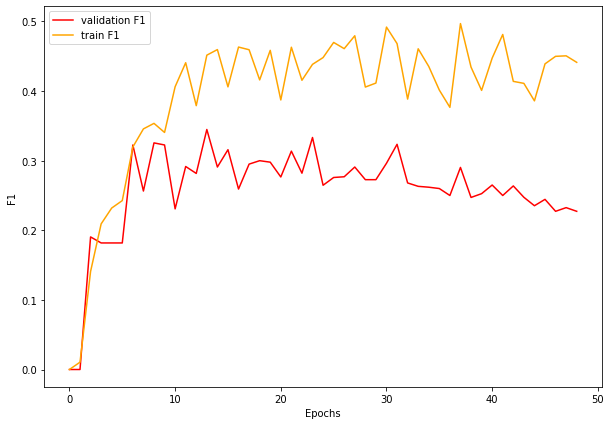

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(f1_scores[0:49], color='red', label='validation F1')
plt.plot(f1_scores_train[0:49], color='orange', label='train F1')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.legend()
#plt.savefig('/content/drive/MyDrive/Owen/loss.png')
plt.show()

              precision    recall  f1-score   support

    no crack       0.94      0.80      0.86       149
     cracked       0.25      0.56      0.34        18

    accuracy                           0.77       167
   macro avg       0.59      0.68      0.60       167
weighted avg       0.86      0.77      0.81       167

[[119  30]
 [  8  10]]


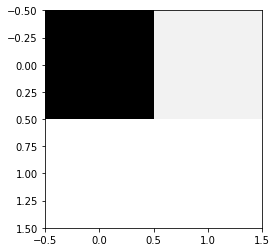

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

target_names = ['no crack', 'cracked']
print(classification_report(road_truths, road_predictions, target_names=target_names))
print(confusion_matrix(road_truths, road_predictions))
test_matrix = confusion_matrix(road_truths, road_predictions)
test_normalised = matrix/matrix.sum(axis=1)[:,None]
plt.imshow(matrix, cmap='binary')

In [ ]:
classification_report(road_truths, road_predictions, target_names=target_names)

' '

              precision    recall  f1-score   support

    no crack       0.91      0.88      0.90      1153
     cracked       0.40      0.49      0.44       189

    accuracy                           0.82      1342
   macro avg       0.66      0.69      0.67      1342
weighted avg       0.84      0.82      0.83      1342

[[1013  140]
 [  96   93]]


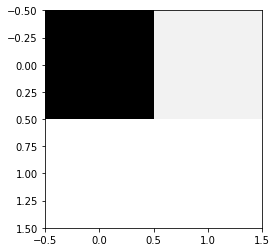

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

target_names = ['no crack', 'cracked']
print(classification_report(road_truths, road_predictions, target_names=target_names))
print(confusion_matrix(road_truths, road_predictions))
train_matrix = confusion_matrix(road_truths, road_predictions)
train_normalised = matrix/matrix.sum(axis=1)[:,None]
plt.imshow(matrix, cmap='binary')

In [ ]:
labelled_data = pd.read_csv("/content/drive/MyDrive/Owen/data/blind_test/test.csv")

In [ ]:
from sklearn.metrics import f1_score
inspection_ids = labelled_data.inspection_id.unique()
inspections_x = labelled_data.inspection_id.values
inspections_y = labelled_data['cracking_binary'].groupby(by=inspections_x).max()
f1_scores_13 = []
path = "/content/drive/MyDrive/Owen/output/epoch" + str(13)
model.load_state_dict(torch.load(path))
model.eval
road_predictions = []
road_truths = []
for i,inspection in tqdm(enumerate(inspection_ids), total=len(inspection_ids)):
    images_x = xtest[inspections_x==inspection]
    images_y = ytest[inspections_x==inspection]
    test_data = pano_images(images_x, images_y, tfms=0)
    with torch.no_grad():
      test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
      for i, data in enumerate(test_dataloader):
        data = data[0].to(device)
        outputs = model(data)
        road_pred = torch.round(torch.max(outputs.data)).item()
        road_truth = max(images_y)
        road_predictions.append(road_pred)
        road_truths.append(road_truth)
f1 = f1_score(road_truths, road_predictions)
print(f1)
f1_scores_13.append(f1)


100%|██████████| 168/168 [00:19<00:00,  8.55it/s]

0.25000000000000006


In [ ]:
print(classification_report(road_truths, road_predictions, target_names=target_names))

              precision    recall  f1-score   support

    no crack       0.95      0.81      0.88       155
     cracked       0.17      0.46      0.25        13

    accuracy                           0.79       168
   macro avg       0.56      0.64      0.56       168
weighted avg       0.89      0.79      0.83       168



In [ ]:
print(confusion_matrix(road_truths, road_predictions))

[[126  29]
 [  7   6]]


In [ ]:
test_data = pano_images(xtest, ytest, tfms=0)
test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
validate(model, test_dataloader)


  0%|          | 0/1 [00:00<?, ?it/s]

Validating



100%|██████████| 1/1 [00:21<00:00, 21.61s/it]

Val Loss: 0.2797, Val Acc: 91.85
Recall: 0.1658, Precision: 0.49, F1: 0.25


(0.27966979146003723, 91.8467183041174, 0.24812030075187969)